## 4 Cross Validation / Hyperparameter Tuning / Model Evaluation

> This script contains the pipeline together with the cross validation, hyperparameter tuning, and model training/evaluation of different models. The feature configurations and transformation methods to be used in the pipeline are also outlined in this notebook.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint
import transformers as tr # custom transformers

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, PredictionErrorDisplay

pd.pandas.set_option('display.max_columns', None)

> Different models will be evaluated: `Linear`, `Polynomial`, `SVR`, and `RandomForest`

> `PowerTransformer` and `FunctionTransformer` are used for Yeo-Johnson, Box-Cox, and Numpy transformations along the features

> MSE, MAE, R2 and a Prediction Error display will be plotted for each model as validation

In [2]:
df = pd.read_csv('Life_Expectancy_Final.csv')
print(df.shape)
df.head()

(2928, 16)


,Country,Year,Status,Adult_Mortality,Infant_Deaths,Alcohol,Bmi,Polio,Total_Expenditure,Diphtheria,Hiv/Aids,Gdp,Thinness_1to19,Income_Composition,Schooling,Life_Expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,19.1,6.0,8.16,65.0,0.1,584.259210,17.2,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,18.6,58.0,8.18,62.0,0.1,612.696514,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,18.1,62.0,8.13,64.0,0.1,631.744976,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,17.6,67.0,8.52,67.0,0.1,669.959000,17.9,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,17.2,68.0,7.87,68.0,0.1,63.537231,18.2,0.454,9.5,59.2


### Train-Test Split

In [3]:
X = df.drop(columns=['Life_Expectancy'])
y = df['Life_Expectancy']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

(2928, 15) (2928,)


((2342, 15), (586, 15))

### Configurations

In [ ]:
NUM_VAR = [var for var in X.columns if X[var].dtype != 'O']
TARGET_VAR = 'Life_Expectancy'
YEO_JOHNSON_VAR = ['Alcohol', 'Thinness_1to19', 'Infant_Deaths',
                   'Total_Expenditure', 'Gdp', 'Schooling']
BOX_COX_VAR = ['Adult_Mortality', 'Hiv/Aids']
WINSOR_VAR = ['Infant_Deaths', 'Total_Expenditure', 'Gdp', 
              'Schooling', 'Adult_Mortality']
SQUARE = ['Income_Composition']
REFLECT_LOG = ['Polio', 'Diphtheria']

full_null = X.groupby('Country')[NUM_VAR].apply(lambda x: x.isna().all())
full_null = full_null[full_null.any(axis=1)]
full_null = full_null.loc[:, full_null.any(axis=0)]
GROUP_NULL = full_null.columns.tolist()

> Features mapped to their respective transformation variable for convenience when referencing in transformers and pipelines

> `GROUP_NULL` contains the columns where they are completely null grouped by Countries. This is to address different imputation methods depending on the missing data.

### Transformers

`Imputation`

> There will be two types of imputation and these will be reflected in the pipeline (from custom transformer script):

> - Country-level missing impute
> - Status-level missing impute

> `Country-level`: features that have at least 1 non-NULL for that country will be imputed with mean value of the country for that feature.

> `Status-level`: features that are ALL NULL for that country will be imputed with the global median value of that feature based on Status (Developing/Developed) matching the country's status.

> This maintains the socioeconomic structure of the countries based on their status. If global median value without status distinction is used then it will oversimplify the variation.

`Transformer`

In [5]:
transform_1 = ColumnTransformer([
    ('yeojohnson', PowerTransformer(method='yeo-johnson'), YEO_JOHNSON_VAR),
    ('boxcox', PowerTransformer(method='box-cox'), BOX_COX_VAR),
    ('square', FunctionTransformer(tr.square_transformer), SQUARE),
    ('reflect_log', FunctionTransformer(tr.reflect_log_transformer), REFLECT_LOG),
], remainder='passthrough').set_output(transform='pandas')

In [6]:
transform_2 = ColumnTransformer([
    ('winsor', tr.Winsorizer(columns=WINSOR_VAR), WINSOR_VAR),
    ('encoder',tr.LOOEncoder(columns=['Country']),['Country']),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), ['Status'])
], remainder='passthrough').set_output(transform='pandas')

In [7]:
scaler = ColumnTransformer([
    ('scale', StandardScaler(), NUM_VAR + ['Country_encoded'])
], remainder='passthrough')

> Leave One Out Encoding is used for `Country` column and this is a wrapper from the custom transformers script. This outputs a new column that is numerical in nature.

> Two ColumnTransformers are used to separate the downstream format and transformations. Before Winsorizing and Leave One Out Encoder, all numerical columns should have been imputed and transformed already. Combining this together into one transformer will have dependency conflicts and errors as they are done in parallel.

In [8]:
y_transform = PowerTransformer(method='yeo-johnson')
y_train = y_transform.fit_transform(y_train.values.reshape(-1,1))
y_test = y_transform.transform(y_test.values.reshape(-1,1))

> Target distribution is also fixed but separate from the `ColumnTransformers` and main pipeline. This will need to be inverse transformed later on in evaluation

### Pipelines

> Each estimator will have their own pipeline for validation

> The sequence is as follows:
> - Impute missing values first
> - Numerical transformations
> - Outlier treatment for numerical features
> - Encoding of categorical features
> - Scaling of numerical features

In [9]:
base_pipe = Pipeline([
    ('country_lvl', tr.CountryLevelImputer(columns_to_impute=NUM_VAR)),
    ('status_lvl', tr.StatusLevelImputer(columns_to_impute=GROUP_NULL)),
    ('transform1', transform_1),
    ('prefix1', tr.RemovePrefix()),
    ('transform2', transform_2),
    ('prefix2', tr.RemovePrefix()),
    ('std', scaler)
])

> `RemovePrefix` is a custom transformer to remove the prefixes from the column names produced by the ColumnTransformers. Each ColumnTransformer already has a function that has a predetermined variable containing the exact names of the columns from the raw data for convenience in `CONFIGURATION` part. If there are no `RemovePrefix` then the output column names from each transformer will need to be hardcoded to each succeeding transformers.

In [10]:
linear_pipe = Pipeline([
    ('base', base_pipe),
    ('regressor', LinearRegression(n_jobs=-1))
])

poly_pipe = Pipeline([
    ('base', base_pipe),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression(n_jobs=-1))
])

svr_pipe = Pipeline([
    ('base', base_pipe),
    ('regressor', SVR(kernel='rbf', C=1.0, epsilon=0.2)) # default settings
])

rf_pipe = Pipeline([
    ('base', base_pipe),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])


In [17]:
linear_pipe.fit(X_train, y_train)

,steps,"[('base', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('country_lvl', ...), ('status_lvl', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,country_col,'Country'
,columns_to_impute,"['Year', 'Adult_Mortality', ...]"
,status_col,'Status'


In [18]:
poly_pipe.fit(X_train, y_train)

,steps,"[('base', ...), ('polynomial', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('country_lvl', ...), ('status_lvl', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,country_col,'Country'
,columns_to_impute,"['Year', 'Adult_Mortality', ...]"
,status_col,'Status'


In [19]:
svr_pipe.fit(X_train, y_train)

c:\Users\zyrvs\Desktop\test\venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,steps,"[('base', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('country_lvl', ...), ('status_lvl', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,country_col,'Country'
,columns_to_impute,"['Year', 'Adult_Mortality', ...]"
,status_col,'Status'


In [20]:
rf_pipe.fit(X_train, y_train)

c:\Users\zyrvs\Desktop\test\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,steps,"[('base', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('country_lvl', ...), ('status_lvl', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,country_col,'Country'
,columns_to_impute,"['Year', 'Adult_Mortality', ...]"
,status_col,'Status'


### Cross-Validation

> The process used here is a standard CV and not a nested CV. For highly rigorous model comparison, a nested CV using a `KFold` for outer and `GridSearchCV` for outer loop with `cross_validate` will tune each model every outer fold but it is slower.

In [21]:
models = {
    'Linear': linear_pipe,
    'Polynomial': poly_pipe,
    'SVR': svr_pipe,
    'RandomForest': rf_pipe,
}

> The prefix `neg` in `mean_squared_error` and `mean_absolute_error` is necessary because `GridSearchCV` by convention maximises the values however these are loss functions so the sign needs to be flipped. 

>`cross_validate` returns a more in-depth scoring and timing including: fit time, scoring time for each fold.

In [ ]:
def evaluate(models, X, y):
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    results = []
    for name, model in models.items():
        cv = cross_validate(model, X, y.ravel(), scoring=scoring, cv=5, n_jobs=-1)
        results.append({
            'model': name,
            'avg_fit_time': cv['fit_time'].mean(), 
            'avg_score_time': cv['score_time'].mean(), 
            'MSE': -cv['test_neg_mean_squared_error'].mean(),
            'MAE': -cv['test_neg_mean_absolute_error'].mean(),
            'R2': cv['test_r2'].mean()})
        
    return pd.DataFrame(results)


def plot_evaluations(results):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    metrics = ['MSE', 'MAE', 'R2']
    times = ['avg_fit_time', 'avg_score_time']
    titles = {
        'MSE': 'mean_squared_error',
        'MAE': 'mean_absolute_error',
        'R2': 'r2_score'
    }
    
    for idx, metric in enumerate(metrics):
        for j, time in enumerate(times):
            ax = axes[j, idx]
            ax.scatter(results[time], results[metric], marker='o')
            for k, model in enumerate(results['model']):
                ax.text(results[time][k], results[metric][k], model)
            ax.set_xlabel(time)
            ax.set_ylabel(titles[metric])
            ax.set_title(f'{time} vs {metric}')
            ax.grid(True)

    plt.tight_layout()
    plt.show()

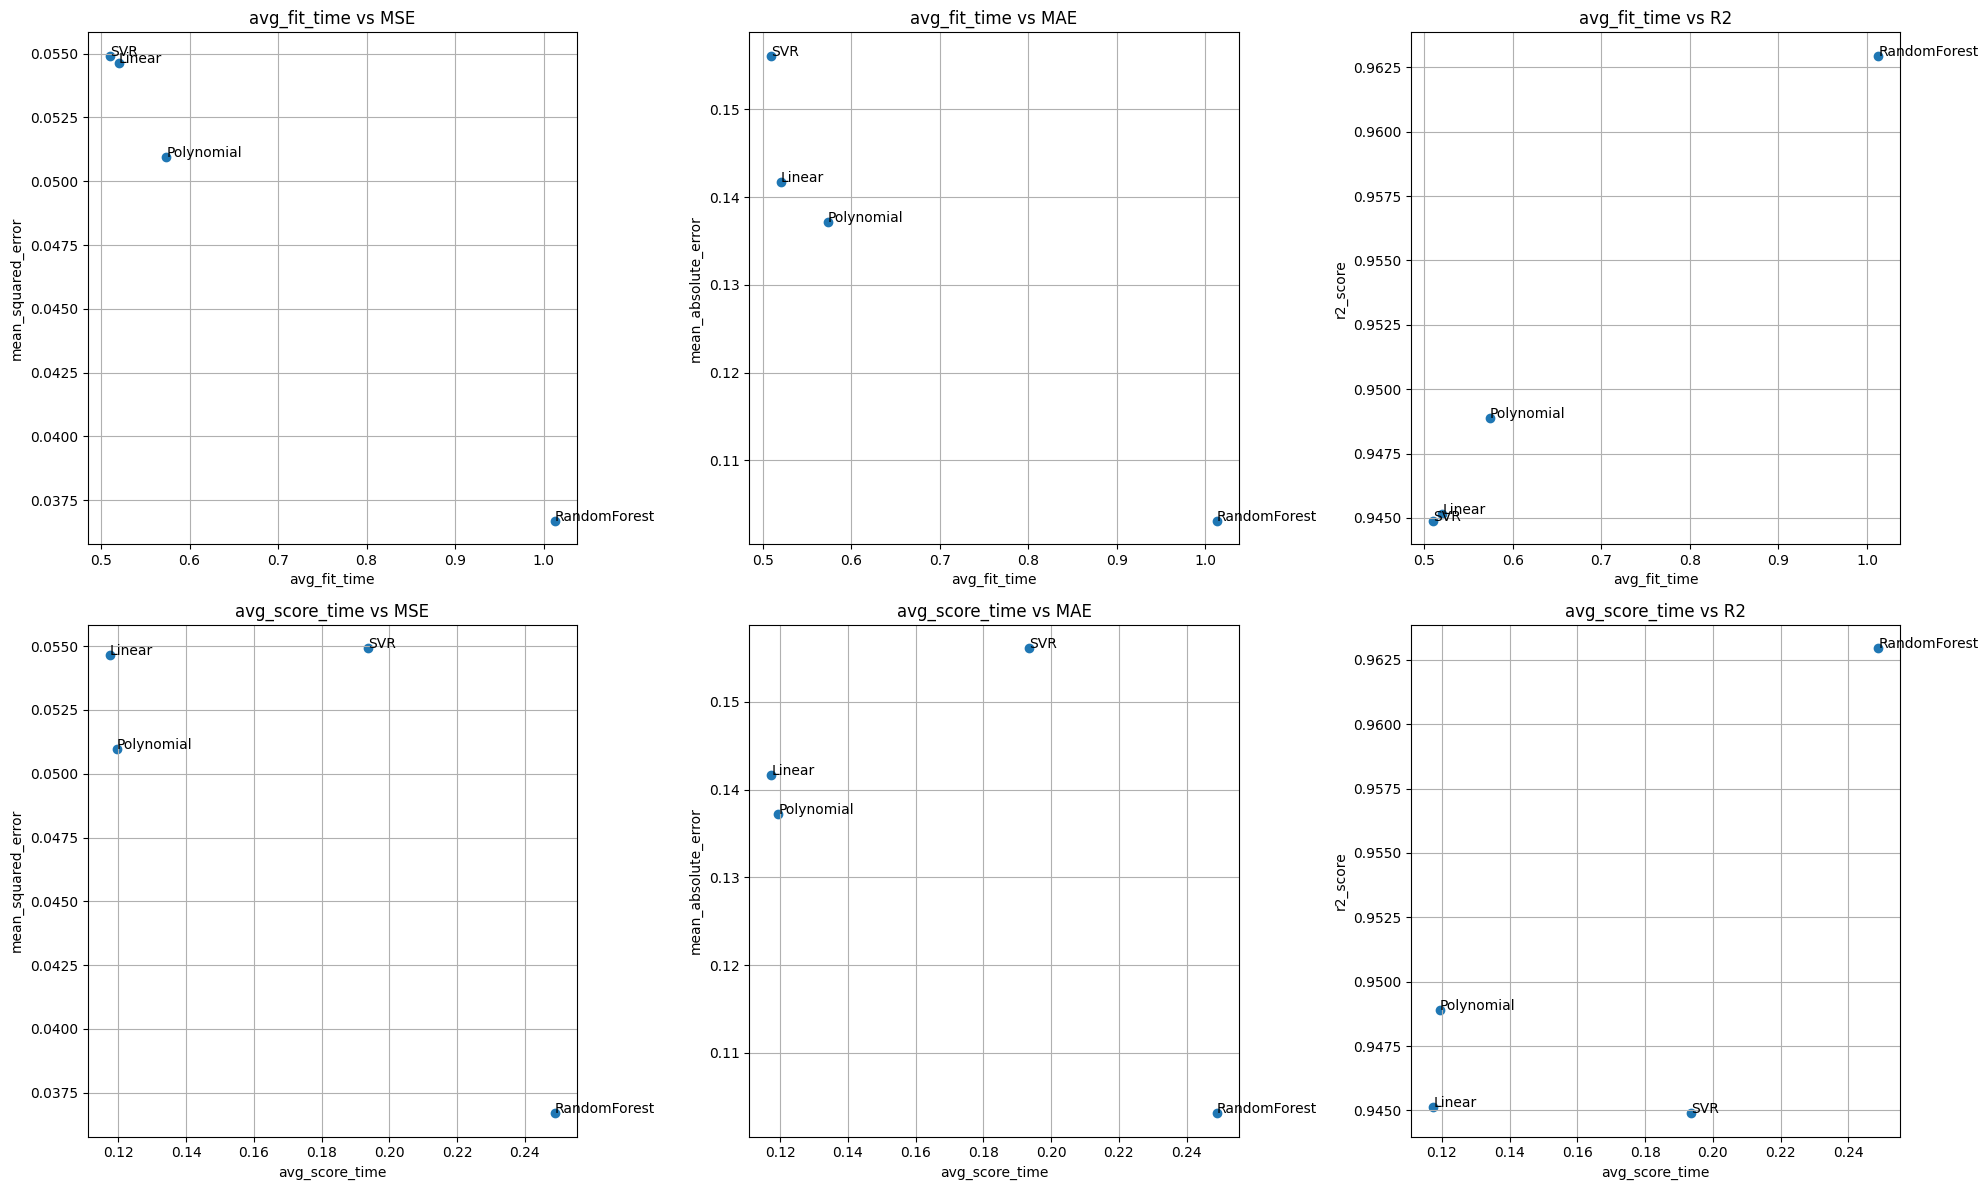

In [29]:
evals = evaluate(models, X_train, y_train)
plot_evaluations(evals)

> In terms of Fit Time and Scoring Time, `RandomForest` is slow but performed better in terms of accuracy. `RandomForest` is the lowest in mean squared and mean absolute error, while `SVR` has the highest error and lowest R^2 score. The performance of polynomial is considerable, has balanced performance in prediction output and fast fit/score time. `RandomForest` is the model to be used in the final pipeline with the hyperparameters tuned.

### Hyperparameter Tuning

In [45]:
param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__min_samples_leaf': [2, 5, 10],
    'regressor__min_samples_split': [5, 10],
}

grid_search = GridSearchCV(
    rf_pipe, param_grid,
    scoring='neg_mean_squared_error', cv=5, n_jobs=-1
)

grid_search.fit(X_train, y_train.ravel())

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [10, 20, ...], 'regressor__max_features': ['sqrt', 'log2'], 'regressor__min_samples_leaf': [2, 5, ...], 'regressor__min_samples_split': [5, 10], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('country_lvl', ...), ('status_lvl', ...), ...]"


> The best performing model from the cross validation process will be used for tuning the parameters

> Mean squared error is used as the scoring parameter for GridSearch and different parameters like `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`, and `min_samples_split` will be evaluated to find the best parameter value with implicit regularisation.

### Model Evaluation - GridSearchCV

In [46]:
grid_search.best_params_

{'regressor__max_depth': 30,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 2,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 100}

> These are the best configuration for the hyperparameters using GridSearchCV

In [47]:
y_pred_train = grid_search.best_estimator_.predict(X_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)

In [48]:
y_train_inv = y_transform.inverse_transform(y_train)
y_test_inv = y_transform.inverse_transform(y_test)
y_pred_train_inv = y_transform.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_inv = y_transform.inverse_transform(y_pred_test.reshape(-1, 1))

mse_train = mean_squared_error(y_train_inv, y_pred_train_inv)
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
r2_train = r2_score(y_train_inv, y_pred_train_inv)

mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2_test = r2_score(y_test_inv, y_pred_test_inv)

print(f'Training set\nMSE: {mse_train}\nMAE: {mae_train}\nR2: {r2_train}\n')
print(f'Testing set\nMSE: {mse_test}\nMAE: {mae_test}\nR2: {r2_test}\n')

Training set
MSE: 0.8966216886274355
MAE: 0.5251338263211867
R2: 0.9902210110367421

Testing set
MSE: 2.4764771329128874
MAE: 0.967503274407674
R2: 0.9713700087351531



> Using `RandomForest` pipeline again with the best parameter configurations yields a favourable result but there is an obvious overfitting due to a higher mean squared error and mean absolute error in the testing set despite having a good r2 score. There are no direct regularisers in RandomForest so testing out different combinations of parameter values might yield a better output.

### RandomizedSearchCV

> RandomizedSearchCV might produce better combination and metric results since GridSearchCV likes to favour complex combinations which results in a suboptimal configuration for the model.

In [51]:
param_dist = {
    'regressor__n_estimators': randint(100, 400),
    'regressor__max_depth': [10, 15, 20, 25],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__min_samples_leaf': [3, 5, 7],
    'regressor__min_samples_split': [5, 10, 15],
}

In [52]:
rand_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rand_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'regressor__max_depth': [10, 15, ...], 'regressor__max_features': ['sqrt', 'log2'], 'regressor__min_samples_leaf': [3, 5, ...], 'regressor__min_samples_split': [5, 10, ...], ...}"
,n_iter,30
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [55]:
rand_search_model = rand_search.best_estimator_
rand_search_params = rand_search.best_params_
rand_search_params

{'regressor__max_depth': 15,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 3,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 256}

In [56]:
y_pred_train = rand_search_model.predict(X_train)
y_pred_test = rand_search_model.predict(X_test)

In [57]:
y_pred_train_inv = y_transform.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_inv = y_transform.inverse_transform(y_pred_test.reshape(-1, 1))
y_train_inv = y_transform.inverse_transform(y_train)
y_test_inv = y_transform.inverse_transform(y_test)

mse_train = mean_squared_error(y_train_inv, y_pred_train_inv)
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
r2_train = r2_score(y_train_inv, y_pred_train_inv)

mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2_test = r2_score(y_test_inv, y_pred_test_inv)

print(f'Training set\nMSE: {mse_train}\nMAE: {mae_train}\nR2: {r2_train}\n')
print(f'Testing set\nMSE: {mse_test}\nMAE: {mae_test}\nR2: {r2_test}\n')

Training set
MSE: 1.1474401659425462
MAE: 0.6067595258988527
R2: 0.9874854636452883

Testing set
MSE: 2.516072938180562
MAE: 0.9842756913548404
R2: 0.9709122505980511



> The gaps are smaller but there is still slight overfitting although the testing error did not increase much which means the model is no longer memorising the training set as aggressive as before.

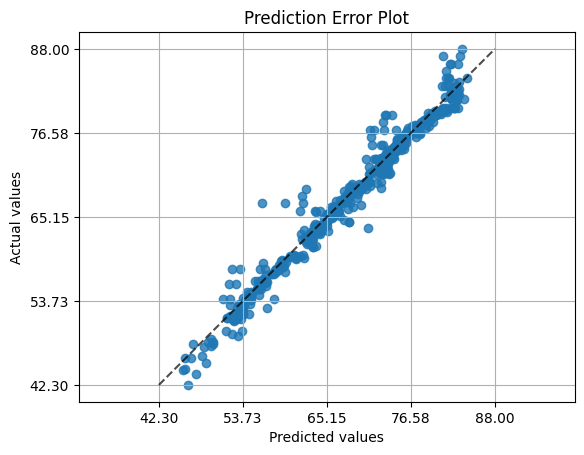

In [58]:
display = PredictionErrorDisplay.from_predictions(
    y_test_inv, y_pred_test_inv,
    kind='actual_vs_predicted'
)

plt.title("Prediction Error Plot")
plt.grid(True)
plt.show()

> The `PredictionErrorDisplay` plot compares the actual target values agains the predicted values for the test set. More data points cluster along the diagonal line indicating the model is accurately predicting the life expectancy. The points are evenly distributed on both sides of the line which means there are no values that are predicted too high or too low in a consistent manner. Although there is some spread on the middle and upper parts, this is kind of expected. The model overall explains the `97.1%` of the variance in the target supported by the `R^2` score.